### Imports

keras - 2.0.5

theano - 0.9.0

And fcn_keras2 script from the Image Segmentation [article](https://aboveintelligent.com/image-segmentation-with-neural-net-d5094d571b1e) [repository](https://github.com/mzaradzki/neuralnets/blob/master/vgg_segmentation_keras/fcn_keras2.py). For more information, check it out step by step.

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import math
import copy

from scipy.misc import bytescale
from scipy.io import loadmat

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import merge

from fcn_keras2 import fcn32_blank, fcn_32s_to_16s, prediction

## Build model architecture

Basic idea behind this: Decapitate each net by discarding the final classifier layer, and convert all fully connected layers to convolutions, to asign a class probability pixelwise.

In [121]:
image_size = 64*8
fcn32model = fcn32_blank(image_size)
fcn16model = fcn_32s_to_16s(fcn32model)
# INFO : dummy image array to test the model passes
imarr = np.ones((image_size,image_size, 3))
imarr = np.expand_dims(imarr, axis=0)
#testmdl = Model(fcn32model.input, fcn32model.layers[10].output) # works fine
testmdl = fcn16model # works fine
testmdl.predict(imarr).shape
if (testmdl.predict(imarr).shape != (1, image_size, image_size, 21)):
    print('WARNING: size mismatch will impact some test cases')

Final structure:

In [122]:
fcn16model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
permute_3_input (InputLayer)     (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
permute_3 (Permute)              (None, 512, 512, 3)   0           permute_3_input[0][0]            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 512, 512, 64)  1792        permute_3[0][0]                  
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 512, 512, 64)  36928       conv1_1[0][0]                    
___________________________________________________________________________________________

Load VGG weigths from the pre-trained model.

Source: http://www.vlfeat.org/matconvnet/pretrained/#semantic-segmentation

In [123]:
data = loadmat('models/pascal-fcn16s-dag.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
p = data['params']
description = data['meta'][0,0].classes[0,0].description
l.shape, p.shape, description.shape

((1, 42), (1, 38), (1, 21))

Classes in this model:

In [124]:
class2index = {}
for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i
    
print(sorted(class2index.keys()))

['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [125]:
# documentation for the dagnn.Crop layer :
# https://github.com/vlfeat/matconvnet/blob/master/matlab/%2Bdagnn/Crop.m

In [126]:
def copy_mat_to_keras(kmodel):
    
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (0, 1, 2, 3) # WARNING : important setting as 2 of the 4 axis have same size dimension
    
    for i in range(0, p.shape[1]-1, 2):
        matname = '_'.join(p[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print('found : ', (str(matname), kindex))
            l_weights = p[0,i].value
            l_bias = p[0,i+1].value
            f_l_weights = l_weights.transpose(prmt)
            if False: # WARNING : this depends on "image_data_format":"channels_last" in keras.json file
                f_l_weights = np.flip(f_l_weights, 0)
                f_l_weights = np.flip(f_l_weights, 1)
            print(f_l_weights.shape, kmodel.layers[kindex].get_weights()[0].shape)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
        else:
            print('not found : ', str(matname))

In [127]:
#copy_mat_to_keras(fcn32model)
copy_mat_to_keras(fcn16model)

('found : ', ('conv1_1', 2))
((3, 3, 3, 64), (3, 3, 3, 64))
('found : ', ('conv1_2', 3))
((3, 3, 64, 64), (3, 3, 64, 64))
('found : ', ('conv2_1', 5))
((3, 3, 64, 128), (3, 3, 64, 128))
('found : ', ('conv2_2', 6))
((3, 3, 128, 128), (3, 3, 128, 128))
('found : ', ('conv3_1', 8))
((3, 3, 128, 256), (3, 3, 128, 256))
('found : ', ('conv3_2', 9))
((3, 3, 256, 256), (3, 3, 256, 256))
('found : ', ('conv3_3', 10))
((3, 3, 256, 256), (3, 3, 256, 256))
('found : ', ('conv4_1', 12))
((3, 3, 256, 512), (3, 3, 256, 512))
('found : ', ('conv4_2', 13))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('conv4_3', 14))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('conv5_1', 16))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('conv5_2', 17))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('conv5_3', 18))
((3, 3, 512, 512), (3, 3, 512, 512))
('found : ', ('fc6', 20))
((7, 7, 512, 4096), (7, 7, 512, 4096))
('found : ', ('fc7', 21))
((1, 1, 4096, 4096), (1, 1, 4096, 4096))
('found : ', ('

## Image segmentation

#### Load Image

(512, 512, 3)


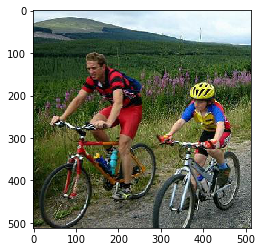

In [165]:
im = Image.open('images/rgb.jpg') # http://www.robots.ox.ac.uk/~szheng/crfasrnndemo/static/rgb.jpg
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((image_size,image_size))
plt.imshow(np.asarray(im))
print(np.asarray(im).shape)

#### Pixel prediction

In [130]:
crpim = im # WARNING : we deal with cropping in a latter section, this image is already fit
preds = prediction(fcn16model, crpim, transform=False) # WARNING : transfrom=True requires a code change (dim order)

#### Plot prediction

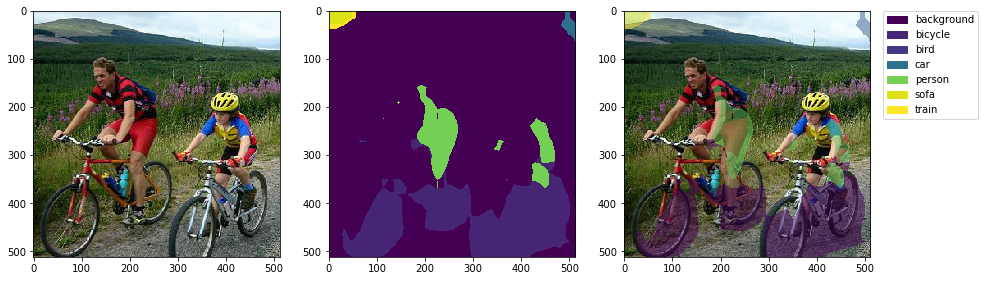

In [131]:
#import matplotlib.patches as mpatches
imclass = np.argmax(preds, axis=3)[0,:,:]
# List of dominant classes found in the image
d={}
values = np.unique(imclass)
for c in values:
    d[c] =str(description[0,c][0])
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
im = plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(crpim) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=d[values[i]]) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

In [25]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

(0, 'background')
(2, 'bicycle')
(3, 'bird')
(7, 'car')
(15, 'person')
(18, 'sofa')
(19, 'train')


#### Bytescale values per relevant class

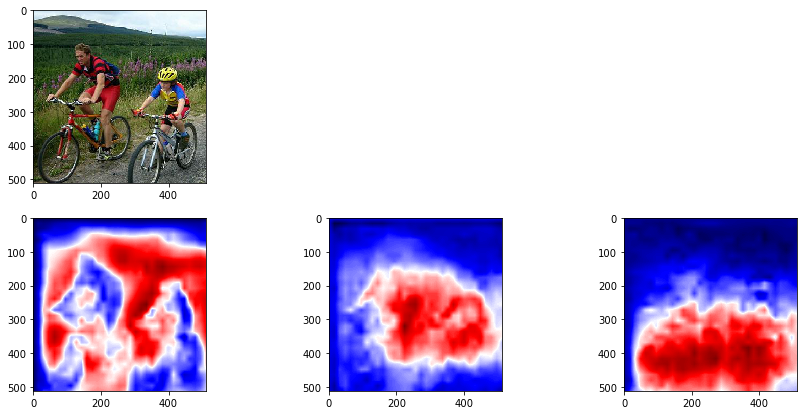

In [26]:
bspreds = bytescale(preds, low=0, high=255)

plt.figure(figsize = (15, 7))
plt.subplot(2,3,1)
plt.imshow(np.asarray(crpim))
plt.subplot(2,3,3+1)
plt.imshow(bspreds[0,:,:,class2index['background']], cmap='seismic')
plt.subplot(2,3,3+2)
plt.imshow(bspreds[0,:,:,class2index['person']], cmap='seismic')
plt.subplot(2,3,3+3)
plt.imshow(bspreds[0,:,:,class2index['bicycle']], cmap='seismic')

## Cow example

#### Load Image

(512, 512, 3)


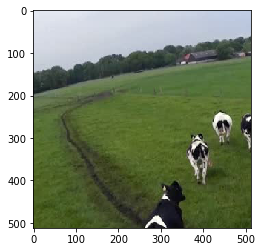

In [132]:
im = Image.open('images/cows.jpg') # http://www.robots.ox.ac.uk/~szheng/crfasrnndemo/static/rgb.jpg
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((image_size,image_size))
plt.imshow(np.asarray(im))
print(np.asarray(im).shape)

#### Pixel Prediction

In [133]:
crpim = im # WARNING : we deal with cropping in a latter section, this image is already fit
preds = prediction(fcn16model, crpim, transform=False) # WARNING : transfrom=True requires a code change (dim order)

#### Plot Prediction

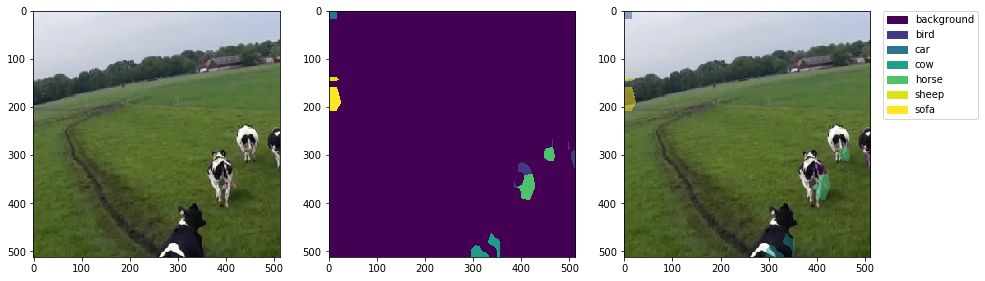

In [134]:
#import matplotlib.patches as mpatches
imclass = np.argmax(preds, axis=3)[0,:,:]
# List of dominant classes found in the image
d={}
values = np.unique(imclass)
for c in values:
    d[c] =str(description[0,c][0])
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
im = plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(crpim) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=d[values[i]]) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

In [136]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

(0, 'background')
(3, 'bird')
(7, 'car')
(10, 'cow')
(13, 'horse')
(17, 'sheep')
(18, 'sofa')


#### Bytescale values per relevant class

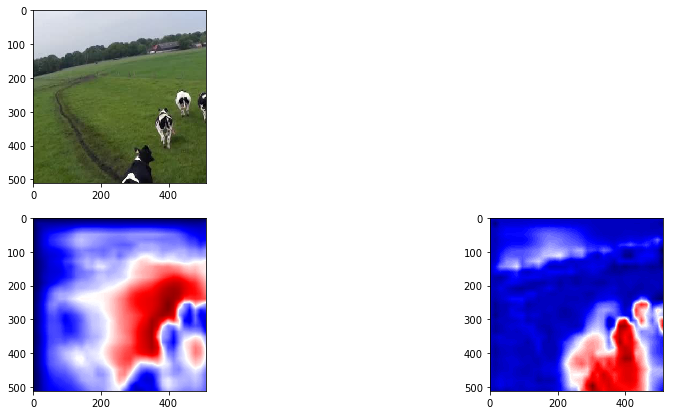

In [164]:
bspreds = bytescale(preds, low=0, high=255)

plt.figure(figsize = (15, 7))
plt.subplot(2,2,1)
plt.imshow(np.asarray(crpim))
plt.subplot(2,2,2+1)
plt.imshow(bspreds[0,:,:,class2index['background']], cmap='seismic')
plt.subplot(2,2,2+2)
plt.imshow(bspreds[0,:,:,class2index['cow']], cmap='seismic')